# Use dataset <u>__7__</u> as test set

In [1]:
from inception_v4 import InceptionV4
from keras.applications.densenet import DenseNet201
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, Dropout, concatenate, Input, Activation, normalization, GlobalAveragePooling1D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model, load_model, model_from_json, Input
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import SaveModelOnMAE_head, generate_generator, read_image_and_K_from_dir, read_48_points


%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
random.seed(7)
net = 'DenseNet201'
with_K = 'head'
idx_test = [17, 13, 20, 21]
save_dir_weights = './weights/weights_' + with_K + '_K/'


# Dataset
dir_path = './data/csv_files'
train_paths, train_labels, train_K, test_paths, test_labels, test_K = read_image_and_K_from_dir(dir_path, idx_test=idx_test)

test_paths_48, test_labels_48, test_K_48 = read_48_points(
    dir_path='./data/csv_files', dir_points='./data/48_points', idx_test=idx_test
)
test_paths_48, test_labels_48, test_K_48 = np.squeeze(test_paths_48).tolist(), np.squeeze(test_labels_48).tolist(), np.squeeze(test_K_48).tolist()

indexes_rand = list(range(len(train_K)))
random.shuffle(indexes_rand)
train_paths, train_labels, train_K = np.asarray(train_paths)[indexes_rand].tolist(), np.asarray(train_labels)[indexes_rand].tolist(), np.asarray(train_K)[indexes_rand].tolist()

idx_validate = np.loadtxt('./data/validation_selection_index.txt').astype(int)
validate_paths, validate_labels, validate_K = np.asarray(test_paths)[idx_validate].tolist(), np.asarray(test_labels)[idx_validate].tolist(), np.asarray(test_K)[idx_validate].tolist()

indexes_rand = list(range(len(test_K)))
random.shuffle(indexes_rand)
test_paths, test_labels, test_K = np.asarray(test_paths)[indexes_rand].tolist(), np.asarray(test_labels)[indexes_rand].tolist(), np.asarray(test_K)[indexes_rand].tolist()

print('\t\tpath\tlabel\tK')
print('train:\t\t{}\t{}\t{}'.format(len(train_paths), len(train_labels), len(train_K)))
print('val:\t\t{}\t{}\t{}'.format(len(validate_paths), len(validate_labels), len(validate_K)))
print('test:\t\t{}\t{}\t{}'.format(len(test_paths), len(test_labels), len(test_K)))
print('test_48:\t{}\t{}\t{}'.format(len(test_paths_48), len(test_labels_48), len(test_K_48)))

/home/chengxg/anaconda2/envs/zp_py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Reading 	train and validation set 	from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
Reading 	test_48 set 			from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
		path	label	K
train:		1047750	1047750	1047750
val:		500	500	500
test:		347700	347700	347700
test_48:	195	195	195


In [2]:
def head_model(input_shape=(150, 150, 4)):
    input_tensor = Input(input_shape)
    x = Conv2D(32, (1, 1), activation='relu', name='head_conv1')(input_tensor)
    x = Conv2D(64, (1, 1), activation='relu', name='head_conv2')(x)
    x = Conv2D(32, (1, 1), activation='relu', name='head_conv3')(x)
    x = Conv2D(3, (1, 1), activation='relu', name='head_conv4')(x)
    model = Model(inputs=input_tensor, outputs=x, name='head')
    return model


if with_K == 'head':
    head_model = head_model()
    body_model = Model(
        inputs=head_model.inputs,
        outputs=DenseNet201(weights='imagenet', include_top=False)(head_model.outputs)
    )
    x = body_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='relu')(x)

    model = Model(inputs=body_model.inputs, outputs=x, name=net)
    model.compile(loss='mean_absolute_error', optimizer='adam')
elif with_K == 'no':
    base_model = DenseNet201(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='relu')(x)
    model = Model(inputs=base_model.inputs, outputs=x, name=net)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 4)       0         
_________________________________________________________________
head_conv1 (Conv2D)          (None, 150, 150, 32)      160       
_________________________________________________________________
head_conv2 (Conv2D)          (None, 150, 150, 64)      2112      
_________________________________________________________________
head_conv3 (Conv2D)          (None, 150, 150, 32)      2080      
_________________________________________________________________
head_conv4 (Conv2D)          (None, 150, 150, 3)       99        
_________________________________________________________________
densenet201 (Model)          multiple                  18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
__________

In [2]:
model = load_model('./acceptable_weights/weights_head_K/DenseNet201_head_K_MAE0.437.hdf5')

In [ ]:
batch_size_train = 4
epochs_per_iteration = 250000
batch_size_validate = len(validate_labels) // 4

if not os.path.exists(save_dir_weights):
    os.mkdir(save_dir_weights)

checkpointer_best = ModelCheckpoint(
    filepath=save_dir_weights + net + '.hdf5',
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)
saver_MAE = SaveModelOnMAE_head()
print('Training ...')
train_generator = generate_generator(train_paths, train_labels, train_K, batch_size_train, net=net, with_K=with_K)
validate_generator = generate_generator(validate_paths, validate_labels, validate_K, batch_size_validate, net=net, with_K=with_K)
history = model.fit_generator(
    train_generator, steps_per_epoch = np.ceil(len(train_paths)/batch_size_train/epochs_per_iteration),
    epochs=epochs_per_iteration * 2,
    validation_data=validate_generator, validation_steps=2,
    verbose=1, callbacks=[checkpointer_best, saver_MAE]
)

Training ...
Epoch 1/500000
2/2 [==============================] - 28s 14s/step - loss: 1.0356 - val_loss: 0.9325

Epoch 00001: val_loss improved from inf to 0.93249, saving model to ./weights/weights_head_K/DenseNet201.hdf5
Epoch 2/500000
2/2 [==============================] - 1s 628ms/step - loss: 0.3622 - val_loss: 1.8359

Epoch 00002: val_loss did not improve from 0.93249
Epoch 3/500000
2/2 [==============================] - 1s 630ms/step - loss: 0.2898 - val_loss: 1.8002

Epoch 00003: val_loss did not improve from 0.93249
Epoch 4/500000
2/2 [==============================] - 1s 630ms/step - loss: 0.2361 - val_loss: 1.5779

Epoch 00004: val_loss did not improve from 0.93249
Epoch 5/500000
2/2 [==============================] - 1s 638ms/step - loss: 0.5426 - val_loss: 1.8417

Epoch 00005: val_loss did not improve from 0.93249
Epoch 6/500000
2/2 [==============================] - 1s 639ms/step - loss: 0.1397 - val_loss: 2.3141

Epoch 00006: val_loss did not improve from 0.93249
Epoch

2/2 [==============================] - 1s 621ms/step - loss: 0.7515 - val_loss: 2.0890

Epoch 00053: val_loss did not improve from 0.59028
Epoch 54/500000
2/2 [==============================] - 1s 659ms/step - loss: 1.0710 - val_loss: 1.6746

Epoch 00054: val_loss did not improve from 0.59028
Epoch 55/500000
2/2 [==============================] - 1s 638ms/step - loss: 0.5903 - val_loss: 1.0616

Epoch 00055: val_loss did not improve from 0.59028
Epoch 56/500000
2/2 [==============================] - 1s 637ms/step - loss: 0.4798 - val_loss: 0.7544

Epoch 00056: val_loss did not improve from 0.59028
Epoch 57/500000
2/2 [==============================] - 1s 647ms/step - loss: 0.3049 - val_loss: 0.4111

Epoch 00057: val_loss improved from 0.59028 to 0.41110, saving model to ./weights/weights_head_K/DenseNet201.hdf5
Saving to weights/weights_head_K/DenseNet201_head_K_MAE0.411.hdf5
Epoch 58/500000
2/2 [==============================] - 1s 652ms/step - loss: 0.6829 - val_loss: 0.4231

Epoch 00

2/2 [==============================] - 1s 676ms/step - loss: 0.5769 - val_loss: 1.5668

Epoch 00105: val_loss did not improve from 0.41110
Epoch 106/500000
2/2 [==============================] - 1s 674ms/step - loss: 0.6498 - val_loss: 1.8547

Epoch 00106: val_loss did not improve from 0.41110
Epoch 107/500000
2/2 [==============================] - 1s 664ms/step - loss: 0.4819 - val_loss: 2.0975

Epoch 00107: val_loss did not improve from 0.41110
Epoch 108/500000
2/2 [==============================] - 1s 649ms/step - loss: 0.3005 - val_loss: 2.2449

Epoch 00108: val_loss did not improve from 0.41110
Epoch 109/500000
2/2 [==============================] - 1s 636ms/step - loss: 0.5701 - val_loss: 2.0254

Epoch 00109: val_loss did not improve from 0.41110
Epoch 110/500000
2/2 [==============================] - 1s 640ms/step - loss: 0.2735 - val_loss: 1.5202

Epoch 00110: val_loss did not improve from 0.41110
Epoch 111/500000
2/2 [==============================] - 1s 629ms/step - loss: 0.4


Epoch 00157: val_loss did not improve from 0.41110
Epoch 158/500000
2/2 [==============================] - 1s 668ms/step - loss: 0.7544 - val_loss: 0.8302

Epoch 00158: val_loss did not improve from 0.41110
Epoch 159/500000
2/2 [==============================] - 1s 666ms/step - loss: 0.5542 - val_loss: 0.9140

Epoch 00159: val_loss did not improve from 0.41110
Epoch 160/500000
2/2 [==============================] - 1s 660ms/step - loss: 0.6974 - val_loss: 1.5969

Epoch 00160: val_loss did not improve from 0.41110
Epoch 161/500000
2/2 [==============================] - 1s 666ms/step - loss: 0.4558 - val_loss: 2.4199

Epoch 00161: val_loss did not improve from 0.41110
Epoch 162/500000
2/2 [==============================] - 1s 634ms/step - loss: 0.5743 - val_loss: 3.1628

Epoch 00162: val_loss did not improve from 0.41110
Epoch 163/500000
2/2 [==============================] - 1s 664ms/step - loss: 1.0274 - val_loss: 3.2953

Epoch 00163: val_loss did not improve from 0.41110
Epoch 164/50

2/2 [==============================] - 1s 660ms/step - loss: 0.2732 - val_loss: 2.4521

Epoch 00210: val_loss did not improve from 0.41110
Epoch 211/500000
2/2 [==============================] - 1s 668ms/step - loss: 0.3173 - val_loss: 2.3038

Epoch 00211: val_loss did not improve from 0.41110
Epoch 212/500000
2/2 [==============================] - 2s 764ms/step - loss: 0.2573 - val_loss: 2.2788

Epoch 00212: val_loss did not improve from 0.41110
Epoch 213/500000
2/2 [==============================] - 1s 666ms/step - loss: 0.4442 - val_loss: 2.1202

Epoch 00213: val_loss did not improve from 0.41110
Epoch 214/500000
2/2 [==============================] - 1s 647ms/step - loss: 0.4215 - val_loss: 2.2221

Epoch 00214: val_loss did not improve from 0.41110
Epoch 215/500000
2/2 [==============================] - 1s 658ms/step - loss: 0.3518 - val_loss: 2.1491

Epoch 00215: val_loss did not improve from 0.41110
Epoch 216/500000
2/2 [==============================] - 1s 653ms/step - loss: 0.3

Epoch 260/500000
2/2 [==============================] - 1s 677ms/step - loss: 0.1619 - val_loss: 0.6274

Epoch 00260: val_loss did not improve from 0.36653
Epoch 261/500000
2/2 [==============================] - 1s 650ms/step - loss: 0.4607 - val_loss: 0.7352

Epoch 00261: val_loss did not improve from 0.36653
Epoch 262/500000
2/2 [==============================] - 1s 652ms/step - loss: 0.4058 - val_loss: 0.6206

Epoch 00262: val_loss did not improve from 0.36653
Epoch 263/500000
2/2 [==============================] - 1s 638ms/step - loss: 0.3368 - val_loss: 0.5718

Epoch 00263: val_loss did not improve from 0.36653
Epoch 264/500000
2/2 [==============================] - 1s 673ms/step - loss: 0.3309 - val_loss: 0.5987

Epoch 00264: val_loss did not improve from 0.36653
Epoch 265/500000
2/2 [==============================] - 1s 647ms/step - loss: 0.4178 - val_loss: 0.5892

Epoch 00265: val_loss did not improve from 0.36653
Epoch 266/500000
2/2 [==============================] - 1s 648ms

2/2 [==============================] - 1s 651ms/step - loss: 0.3848 - val_loss: 1.1317

Epoch 00312: val_loss did not improve from 0.36653
Epoch 313/500000
2/2 [==============================] - 1s 643ms/step - loss: 0.4826 - val_loss: 1.0716

Epoch 00313: val_loss did not improve from 0.36653
Epoch 314/500000
2/2 [==============================] - 1s 674ms/step - loss: 0.4361 - val_loss: 1.1379

Epoch 00314: val_loss did not improve from 0.36653
Epoch 315/500000
2/2 [==============================] - 1s 626ms/step - loss: 0.2356 - val_loss: 1.2052

Epoch 00315: val_loss did not improve from 0.36653
Epoch 316/500000
2/2 [==============================] - 1s 650ms/step - loss: 0.2978 - val_loss: 1.4250

Epoch 00316: val_loss did not improve from 0.36653
Epoch 317/500000
2/2 [==============================] - 1s 640ms/step - loss: 0.5305 - val_loss: 1.8712

Epoch 00317: val_loss did not improve from 0.36653
Epoch 318/500000
2/2 [==============================] - 1s 658ms/step - loss: 0.6


Epoch 00364: val_loss did not improve from 0.36653
Epoch 365/500000
2/2 [==============================] - 1s 644ms/step - loss: 0.3488 - val_loss: 2.0801

Epoch 00365: val_loss did not improve from 0.36653
Epoch 366/500000
2/2 [==============================] - 1s 684ms/step - loss: 0.2663 - val_loss: 1.9554

Epoch 00366: val_loss did not improve from 0.36653
Epoch 367/500000
2/2 [==============================] - 1s 654ms/step - loss: 0.2422 - val_loss: 1.5140

Epoch 00367: val_loss did not improve from 0.36653
Epoch 368/500000
2/2 [==============================] - 1s 654ms/step - loss: 0.4137 - val_loss: 1.0128

Epoch 00368: val_loss did not improve from 0.36653
Epoch 369/500000
2/2 [==============================] - 1s 645ms/step - loss: 0.5062 - val_loss: 0.9199

Epoch 00369: val_loss did not improve from 0.36653
Epoch 370/500000
2/2 [==============================] - 1s 669ms/step - loss: 0.4643 - val_loss: 1.2541

Epoch 00370: val_loss did not improve from 0.36653
Epoch 371/50

2/2 [==============================] - 1s 654ms/step - loss: 0.5371 - val_loss: 1.5828

Epoch 00416: val_loss did not improve from 0.36653
Epoch 417/500000
2/2 [==============================] - 1s 678ms/step - loss: 0.2533 - val_loss: 1.8556

Epoch 00417: val_loss did not improve from 0.36653
Epoch 418/500000
2/2 [==============================] - 1s 644ms/step - loss: 0.2662 - val_loss: 1.9052

Epoch 00418: val_loss did not improve from 0.36653
Epoch 419/500000
2/2 [==============================] - 1s 653ms/step - loss: 0.2550 - val_loss: 1.7040

Epoch 00419: val_loss did not improve from 0.36653
Epoch 420/500000
2/2 [==============================] - 1s 645ms/step - loss: 0.3131 - val_loss: 1.5381

Epoch 00420: val_loss did not improve from 0.36653
Epoch 421/500000
2/2 [==============================] - 1s 638ms/step - loss: 0.2313 - val_loss: 1.5573

Epoch 00421: val_loss did not improve from 0.36653
Epoch 422/500000
2/2 [==============================] - 1s 630ms/step - loss: 0.1


Epoch 00468: val_loss did not improve from 0.36653
Epoch 469/500000
2/2 [==============================] - 1s 642ms/step - loss: 0.5159 - val_loss: 1.0615

Epoch 00469: val_loss did not improve from 0.36653
Epoch 470/500000
2/2 [==============================] - 1s 677ms/step - loss: 0.2387 - val_loss: 1.3142

Epoch 00470: val_loss did not improve from 0.36653
Epoch 471/500000
2/2 [==============================] - 1s 674ms/step - loss: 0.1957 - val_loss: 1.4789

Epoch 00471: val_loss did not improve from 0.36653
Epoch 472/500000
2/2 [==============================] - 1s 677ms/step - loss: 0.3938 - val_loss: 1.6779

Epoch 00472: val_loss did not improve from 0.36653
Epoch 473/500000
2/2 [==============================] - 1s 667ms/step - loss: 0.3488 - val_loss: 1.6091

Epoch 00473: val_loss did not improve from 0.36653
Epoch 474/500000
2/2 [==============================] - 1s 670ms/step - loss: 0.1863 - val_loss: 1.4049

Epoch 00474: val_loss did not improve from 0.36653
Epoch 475/50

2/2 [==============================] - 1s 677ms/step - loss: 0.3707 - val_loss: 2.0909

Epoch 00521: val_loss did not improve from 0.36653
Epoch 522/500000
2/2 [==============================] - 1s 667ms/step - loss: 0.3265 - val_loss: 1.8496

Epoch 00522: val_loss did not improve from 0.36653
Epoch 523/500000
2/2 [==============================] - 1s 636ms/step - loss: 0.3092 - val_loss: 1.6628

Epoch 00523: val_loss did not improve from 0.36653
Epoch 524/500000
2/2 [==============================] - 1s 679ms/step - loss: 0.6253 - val_loss: 1.8123

Epoch 00524: val_loss did not improve from 0.36653
Epoch 525/500000
2/2 [==============================] - 1s 663ms/step - loss: 0.5615 - val_loss: 2.3114

Epoch 00525: val_loss did not improve from 0.36653
Epoch 526/500000
2/2 [==============================] - 1s 663ms/step - loss: 0.3952 - val_loss: 2.8413

Epoch 00526: val_loss did not improve from 0.36653
Epoch 527/500000
2/2 [==============================] - 1s 646ms/step - loss: 0.4


Epoch 00573: val_loss did not improve from 0.36653
Epoch 574/500000
2/2 [==============================] - 1s 638ms/step - loss: 0.3598 - val_loss: 1.7521

Epoch 00574: val_loss did not improve from 0.36653
Epoch 575/500000
2/2 [==============================] - 1s 650ms/step - loss: 0.2703 - val_loss: 1.6707

Epoch 00575: val_loss did not improve from 0.36653
Epoch 576/500000
2/2 [==============================] - 1s 689ms/step - loss: 0.4025 - val_loss: 1.7263

Epoch 00576: val_loss did not improve from 0.36653
Epoch 577/500000
2/2 [==============================] - 1s 640ms/step - loss: 0.3696 - val_loss: 1.6382

Epoch 00577: val_loss did not improve from 0.36653
Epoch 578/500000
2/2 [==============================] - 1s 658ms/step - loss: 0.2598 - val_loss: 1.7173

Epoch 00578: val_loss did not improve from 0.36653
Epoch 579/500000
2/2 [==============================] - 1s 641ms/step - loss: 0.1933 - val_loss: 1.6529

Epoch 00579: val_loss did not improve from 0.36653
Epoch 580/50

2/2 [==============================] - 1s 684ms/step - loss: 0.5451 - val_loss: 1.5174

Epoch 00626: val_loss did not improve from 0.36653
Epoch 627/500000
2/2 [==============================] - 1s 655ms/step - loss: 0.3523 - val_loss: 1.7243

Epoch 00627: val_loss did not improve from 0.36653
Epoch 628/500000
2/2 [==============================] - 1s 660ms/step - loss: 0.1386 - val_loss: 2.3251

Epoch 00628: val_loss did not improve from 0.36653
Epoch 629/500000
2/2 [==============================] - 1s 654ms/step - loss: 0.6366 - val_loss: 2.5227

Epoch 00629: val_loss did not improve from 0.36653
Epoch 630/500000
2/2 [==============================] - 1s 662ms/step - loss: 0.7477 - val_loss: 2.4626

Epoch 00630: val_loss did not improve from 0.36653
Epoch 631/500000
2/2 [==============================] - 1s 662ms/step - loss: 0.4382 - val_loss: 1.9312

Epoch 00631: val_loss did not improve from 0.36653
Epoch 632/500000
2/2 [==============================] - 1s 671ms/step - loss: 0.3


Epoch 00678: val_loss did not improve from 0.36653
Epoch 679/500000
2/2 [==============================] - 1s 655ms/step - loss: 0.3060 - val_loss: 1.5017

Epoch 00679: val_loss did not improve from 0.36653
Epoch 680/500000
2/2 [==============================] - 1s 650ms/step - loss: 0.3100 - val_loss: 1.2226

Epoch 00680: val_loss did not improve from 0.36653
Epoch 681/500000
2/2 [==============================] - 1s 670ms/step - loss: 0.4362 - val_loss: 1.1256

Epoch 00681: val_loss did not improve from 0.36653
Epoch 682/500000
2/2 [==============================] - 1s 691ms/step - loss: 0.2461 - val_loss: 1.2231

Epoch 00682: val_loss did not improve from 0.36653
Epoch 683/500000
2/2 [==============================] - 1s 655ms/step - loss: 0.2972 - val_loss: 1.5389

Epoch 00683: val_loss did not improve from 0.36653
Epoch 684/500000
2/2 [==============================] - 1s 653ms/step - loss: 0.3467 - val_loss: 2.0682

Epoch 00684: val_loss did not improve from 0.36653
Epoch 685/50

2/2 [==============================] - 1s 637ms/step - loss: 0.3398 - val_loss: 1.0930

Epoch 00731: val_loss did not improve from 0.36653
Epoch 732/500000
2/2 [==============================] - 1s 647ms/step - loss: 0.4637 - val_loss: 1.4983

Epoch 00732: val_loss did not improve from 0.36653
Epoch 733/500000
2/2 [==============================] - 1s 630ms/step - loss: 0.5250 - val_loss: 1.6171

Epoch 00733: val_loss did not improve from 0.36653
Epoch 734/500000
2/2 [==============================] - 1s 635ms/step - loss: 0.2481 - val_loss: 1.3789

Epoch 00734: val_loss did not improve from 0.36653
Epoch 735/500000
2/2 [==============================] - 1s 645ms/step - loss: 0.3148 - val_loss: 1.0840

Epoch 00735: val_loss did not improve from 0.36653
Epoch 736/500000
2/2 [==============================] - 1s 641ms/step - loss: 0.3935 - val_loss: 0.8329

Epoch 00736: val_loss did not improve from 0.36653
Epoch 737/500000
2/2 [==============================] - 1s 664ms/step - loss: 0.4


Epoch 00783: val_loss did not improve from 0.36653
Epoch 784/500000
2/2 [==============================] - 1s 638ms/step - loss: 0.2118 - val_loss: 1.0227

Epoch 00784: val_loss did not improve from 0.36653
Epoch 785/500000
2/2 [==============================] - 1s 627ms/step - loss: 0.2202 - val_loss: 0.6621

Epoch 00785: val_loss did not improve from 0.36653
Epoch 786/500000
2/2 [==============================] - 1s 659ms/step - loss: 0.3949 - val_loss: 0.6478

Epoch 00786: val_loss did not improve from 0.36653
Epoch 787/500000
2/2 [==============================] - 1s 654ms/step - loss: 0.4502 - val_loss: 0.6237

Epoch 00787: val_loss did not improve from 0.36653
Epoch 788/500000
2/2 [==============================] - 1s 642ms/step - loss: 0.2661 - val_loss: 0.9038

Epoch 00788: val_loss did not improve from 0.36653
Epoch 789/500000
2/2 [==============================] - 1s 639ms/step - loss: 0.3074 - val_loss: 1.0816

Epoch 00789: val_loss did not improve from 0.36653
Epoch 790/50

2/2 [==============================] - 1s 654ms/step - loss: 0.6682 - val_loss: 1.1186

Epoch 00836: val_loss did not improve from 0.36653
Epoch 837/500000
2/2 [==============================] - 1s 638ms/step - loss: 0.2751 - val_loss: 0.7034

Epoch 00837: val_loss did not improve from 0.36653
Epoch 838/500000
2/2 [==============================] - 1s 636ms/step - loss: 0.2919 - val_loss: 0.5752

Epoch 00838: val_loss did not improve from 0.36653
Epoch 839/500000
2/2 [==============================] - 1s 647ms/step - loss: 0.2989 - val_loss: 0.4583

Epoch 00839: val_loss did not improve from 0.36653
Epoch 840/500000
2/2 [==============================] - 1s 646ms/step - loss: 0.2910 - val_loss: 0.5585

Epoch 00840: val_loss did not improve from 0.36653
Epoch 841/500000
2/2 [==============================] - 1s 624ms/step - loss: 0.2408 - val_loss: 0.6178

Epoch 00841: val_loss did not improve from 0.36653
Epoch 842/500000
2/2 [==============================] - 1s 668ms/step - loss: 0.2

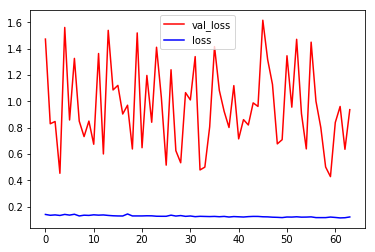

In [6]:
vl, l = history.history['val_loss'], history.history['loss']
vl = np.asarray(vl)
th = 3
vl[vl > th] = th
plt.plot(vl, 'r')
plt.plot(l, 'b')
plt.legend(['val_loss', 'loss'])
plt.show()

1/4 Loading ./weights/weights_head_K/DenseNet201_head_K_MAE0.346.hdf5 ...
(195,)


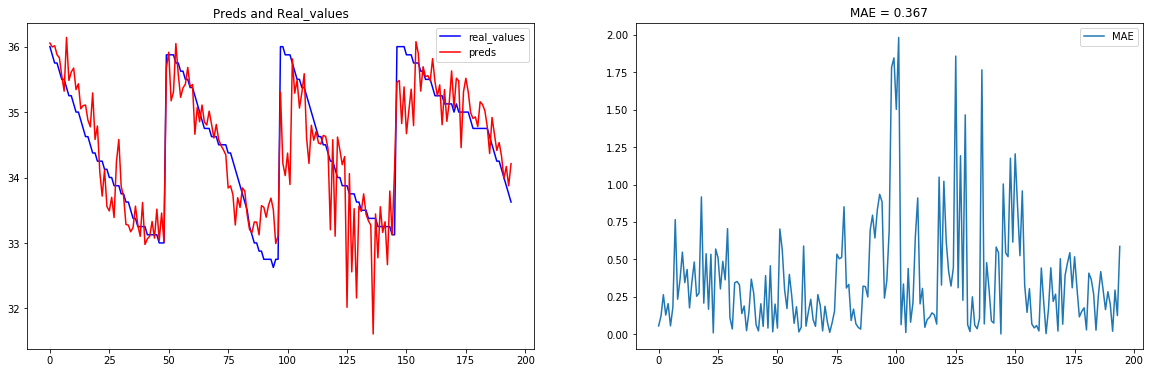

In [2]:
# test
model_paths = sorted([save_dir_weights+i for i in os.listdir(save_dir_weights) if 'MAE' in i], key=lambda x: float(x.split('MAE')[-1][:-len('.hdf5')]), reverse=False)[:4]
cursor = 0
# model_paths = ['weights/weights_head_K/DenseNet201_head_K_MAE0.429.hdf5']
for idx, m in enumerate(model_paths[cursor:cursor+1]):
    print('{}/{} Loading'.format(idx+1+cursor, len(model_paths)), m, '...')
    model = load_model(m)
    generator_for_test = generate_generator(test_paths_48, test_labels_48, test_K_48, len(test_K_48), net=net, with_K=with_K)
    X_test, Y_test = generator_for_test.__next__()
    preds = np.squeeze(model.predict(X_test))
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 6))
    ax0.plot(Y_test, 'b')
    ax0.plot(preds, 'r')
    ax0.legend(['real_values', 'preds'])
    ax0.set_title('Preds and Real_values')
    ax1.plot(np.abs(preds - Y_test))
    ax1.legend(['MAE'])
    MAE = round(np.mean(abs(preds - Y_test)), 3)
    ax1.set_title('MAE = {}'.format(MAE))
    print(np.unique(preds).shape)
    plt.show()

In [3]:
import pandas as pd
label_pred = np.hstack([np.asarray(range(Y_test.shape[0])).reshape(-1, 1), Y_test.reshape(-1, 1), preds.reshape(-1, 1)])
label_pred = pd.DataFrame(label_pred)
label_pred.to_csv(
    os.path.join('preds', 'preds_' + with_K + '_K', '_'.join([net, with_K, 'K_MAE', str(MAE) + '.txt'])),
    index=None,
    header=['index', 'label', 'prediction']
)